# Preprocessing RoadTrafficAccidents

In [1]:
import pandas as pd
import os
import datetime
import math
import numpy as np

Getting the full path to the dataset folder

In [2]:
dir_path = os.path.dirname(os.path.realpath("__file__"))
path_to_datasets_folder = os.path.join(dir_path, "datasets")
path_to_accidents_file = os.path.join(path_to_datasets_folder, "RoadTrafficAccidentLocations.csv")

Reading the TrafficAccident file and remove all language duplicates

In [3]:
df_accidents = pd.read_csv(path_to_accidents_file)
df_accidents = df_accidents.drop(columns=['AccidentType_de', 'AccidentType_fr', 'AccidentType_it'])
df_accidents = df_accidents.drop(columns=['AccidentSeverityCategory_de', 'AccidentSeverityCategory_fr', 'AccidentSeverityCategory_it'])
df_accidents = df_accidents.drop(columns=['RoadType_de', 'RoadType_fr', 'RoadType_it'])
df_accidents = df_accidents.drop(columns=['AccidentMonth_de', 'AccidentMonth_fr','AccidentMonth_it'])
df_accidents = df_accidents.drop(columns=['AccidentWeekDay_de', 'AccidentWeekDay_fr', 'AccidentWeekDay_it'])
df_accidents.head()

,AccidentUID,AccidentType,AccidentType_en,AccidentSeverityCategory,AccidentSeverityCategory_en,AccidentInvolvingPedestrian,AccidentInvolvingBicycle,AccidentInvolvingMotorcycle,RoadType,RoadType_en,...,AccidentLocation_CHLV95_N,CantonCode,MunicipalityCode,AccidentYear,AccidentMonth,AccidentMonth_en,AccidentWeekDay,AccidentWeekDay_en,AccidentHour,AccidentHour_text
0,A2D2677533867004E0430A865E337004,at0,Accident with skidding or self-accident,as4,Accident with property damage,False,False,False,rt433,Minor road,...,1245194,ZH,261,2011,1,January,aw406,Saturday,0.0,00h-01h
1,9FD6441F802C20A6E0430A865E3320A6,at0,Accident with skidding or self-accident,as3,Accident with light injuries,False,True,False,rt433,Minor road,...,1246980,ZH,261,2011,1,January,aw406,Saturday,1.0,01h-02h
2,9FDA0DC4856A6094E0430A865E336094,at0,Accident with skidding or self-accident,as4,Accident with property damage,False,False,False,rt439,Other,...,1247749,ZH,261,2011,1,January,aw406,Saturday,2.0,02h-03h
3,A3B66E42396E6000E0430A865E336000,at5,Accident when crossing the lane(s),as3,Accident with light injuries,False,False,False,rt433,Minor road,...,1247102,ZH,261,2011,1,January,aw406,Saturday,2.0,02h-03h
4,9FDA0DBE8CCE9096E0430A865E339096,at0,Accident with skidding or self-accident,as4,Accident with property damage,False,False,False,rt433,Minor road,...,1250690,ZH,261,2011,1,January,aw406,Saturday,3.0,03h-04h


create the correct datetime for each row and add 'nan' as value in the date row if the accident hour is missing (rows cases)

In [4]:
df_accidents.head().shape #dims of cleaned dataset

(5, 21)

In [5]:
df_accidents.dtypes #might think about one hot encoding for categ columns, which appear to be the 'object' columns

AccidentUID                     object
AccidentType                    object
AccidentType_en                 object
AccidentSeverityCategory        object
AccidentSeverityCategory_en     object
AccidentInvolvingPedestrian       bool
AccidentInvolvingBicycle          bool
AccidentInvolvingMotorcycle       bool
RoadType                        object
RoadType_en                     object
AccidentLocation_CHLV95_E        int64
AccidentLocation_CHLV95_N        int64
CantonCode                      object
MunicipalityCode                 int64
AccidentYear                     int64
AccidentMonth                    int64
AccidentMonth_en                object
AccidentWeekDay                 object
AccidentWeekDay_en              object
AccidentHour                   float64
AccidentHour_text               object
dtype: object

In [6]:
from collections import Counter

#count NaNs in dataset:
for i in df_accidents.columns:
    print(Counter(list(df_accidents[i].isna()))[1])

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
4
0


In [7]:
#one way of checking positions of NaNs in dataset and get corresponding columns:
nan_positions = [(row, index) for index, row in df_accidents.iterrows() if row.isnull().any()]
nan_positions

[(AccidentUID                           B74241C848E101A8E0430A83942701A8
  AccidentType                                                       at0
  AccidentType_en                Accident with skidding or self-accident
  AccidentSeverityCategory                                           as4
  AccidentSeverityCategory_en              Accident with property damage
  AccidentInvolvingPedestrian                                      False
  AccidentInvolvingBicycle                                         False
  AccidentInvolvingMotorcycle                                      False
  RoadType                                                         rt430
  RoadType_en                                                   Motorway
  AccidentLocation_CHLV95_E                                      2681888
  AccidentLocation_CHLV95_N                                      1246482
  CantonCode                                                          ZH
  MunicipalityCode                                 

In [8]:
#another way of checking positions of NaNs in dataset and get corresponding columns:
idx, idy = np.where(pd.isnull(df_accidents))
idx, df_accidents.columns[idy]

(array([3149, 5749, 7436, 8193], dtype=int64),
 Index(['AccidentHour', 'AccidentHour', 'AccidentHour', 'AccidentHour'], dtype='object'))

In [9]:
df_accidents = df_accidents[df_accidents['AccidentYear'] != 2020]

Count days in every year's month... This is needed to check whether we have data for every day of each year in order to pin down the exact date:


In [129]:
from itertools import groupby

#count number of distinct days in each month for every year:
for j in years:
    
    days_per_month = []
    
    for i in months:
        z = pd.Series(zip([[len([v]), k] for k, v in groupby(df_accidents[(df_accidents['AccidentYear'] == j) & (df_accidents['AccidentMonth'] == i)]['AccidentWeekDay'])]))
        item_counts = z.index.value_counts(normalize=False)
        days_per_month.append(item_counts.sum())
        
    print('{}:'.format(j), days_per_month)



2011: [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
2012: [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
2013: [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
2014: [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
2015: [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
2016: [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
2017: [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
2018: [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
2019: [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]


In [10]:
#counting entries in every year's months:

import calendar

years = np.arange(2011,2020,1).tolist()
months = np.arange(1,13,1).tolist()


for j in years:
    
    dict_ = {}
    
    for i in months:
        row_dim = df_accidents[(df_accidents['AccidentYear'] == j) & (df_accidents['AccidentMonth'] == i)].shape[0]
        months_name = calendar.month_name[i]
        dict_[months_name[:3]] = row_dim
    
    print('{}:'.format(j), dict_)
    print('')

2011: {'Jan': 274, 'Feb': 221, 'Mar': 288, 'Apr': 324, 'May': 360, 'Jun': 310, 'Jul': 290, 'Aug': 343, 'Sep': 332, 'Oct': 324, 'Nov': 305, 'Dec': 319}

2012: {'Jan': 269, 'Feb': 239, 'Mar': 340, 'Apr': 290, 'May': 306, 'Jun': 309, 'Jul': 307, 'Aug': 305, 'Sep': 280, 'Oct': 289, 'Nov': 322, 'Dec': 279}

2013: {'Jan': 242, 'Feb': 227, 'Mar': 299, 'Apr': 305, 'May': 332, 'Jun': 372, 'Jul': 337, 'Aug': 323, 'Sep': 299, 'Oct': 328, 'Nov': 314, 'Dec': 267}

2014: {'Jan': 247, 'Feb': 260, 'Mar': 321, 'Apr': 301, 'May': 311, 'Jun': 388, 'Jul': 294, 'Aug': 299, 'Sep': 301, 'Oct': 313, 'Nov': 252, 'Dec': 263}

2015: {'Jan': 249, 'Feb': 246, 'Mar': 298, 'Apr': 288, 'May': 324, 'Jun': 356, 'Jul': 550, 'Aug': 491, 'Sep': 512, 'Oct': 511, 'Nov': 519, 'Dec': 447}

2016: {'Jan': 450, 'Feb': 396, 'Mar': 420, 'Apr': 514, 'May': 549, 'Jun': 554, 'Jul': 478, 'Aug': 504, 'Sep': 546, 'Oct': 515, 'Nov': 480, 'Dec': 412}

2017: {'Jan': 411, 'Feb': 398, 'Mar': 543, 'Apr': 457, 'May': 547, 'Jun': 536, 'Jul': 49

### Visualizations

In [11]:
import matplotlib.pyplot as plt

In [12]:
dict_1 = {}

for j in years:
    accidents_list = []
    
    for i in months:
        row_dim = df_accidents[(df_accidents['AccidentYear'] == j) & (df_accidents['AccidentMonth'] == i)].shape[0]
        accidents_list.append(row_dim)
    dict_1['{}'.format(j)] = [i for i in accidents_list]
    
dict_1

{'2011': [274, 221, 288, 324, 360, 310, 290, 343, 332, 324, 305, 319],
 '2012': [269, 239, 340, 290, 306, 309, 307, 305, 280, 289, 322, 279],
 '2013': [242, 227, 299, 305, 332, 372, 337, 323, 299, 328, 314, 267],
 '2014': [247, 260, 321, 301, 311, 388, 294, 299, 301, 313, 252, 263],
 '2015': [249, 246, 298, 288, 324, 356, 550, 491, 512, 511, 519, 447],
 '2016': [450, 396, 420, 514, 549, 554, 478, 504, 546, 515, 480, 412],
 '2017': [411, 398, 543, 457, 547, 536, 495, 506, 476, 494, 518, 466],
 '2018': [398, 331, 522, 533, 531, 578, 571, 525, 489, 542, 527, 460],
 '2019': [400, 414, 473, 468, 496, 591, 545, 508, 510, 520, 510, 412]}

- Average number of monthly accidents:

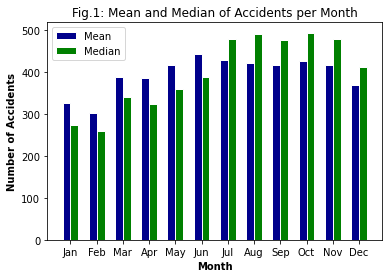

In [127]:
monthly_avgs_dict = {}

for j in range(12):
    
    month_list = []
    
    for key, value in dict_1.items():
        month_list.append(value[j]) #stores the number of accidents of the same month for every year
    months_name = calendar.month_name[j+1]
    monthly_avgs_dict[months_name[:3]] = [np.mean(month_list), np.median(month_list)] #stores the average number of accidents for each month


# set heights of bars
bars1 = [value[0] for key, value in monthly_avgs_dict.items()]
bars2 = [value[1] for key, value in monthly_avgs_dict.items()]
 
barWidth = 0.3

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Make the plot
plt.bar(r1, bars1, width=barWidth, color='darkblue', edgecolor='white', label='Mean')
plt.bar(r2, bars2, width=barWidth, color='green', edgecolor='white', label='Median')

plt.title('Fig.1: Mean and Median of Accidents per Month', fontsize = 12)
plt.xlabel('Month', fontweight='bold')
plt.ylabel('Number of Accidents', fontweight='bold')
plt.xticks([r + (barWidth-0.15) for r in range(len(bars1))], list(monthly_avgs_dict.keys()))


# Create legend & Show graphic
plt.legend()
plt.show()

- Average number of yearly accidents:

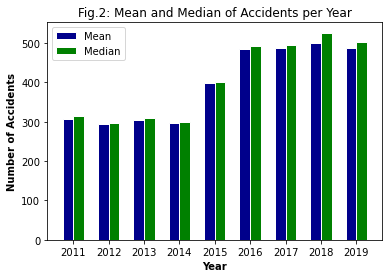

In [128]:
yearly_avgs_dict = {}

for key, value in dict_1.items():
    yearly_avgs_dict[key] = [np.mean(value), np.median(value)] #stores the average number of accidents per year
    

# set heights of bars
bars1 = [value[0] for key, value in yearly_avgs_dict.items()]
bars2 = [value[1] for key, value in yearly_avgs_dict.items()]
 
barWidth = 0.3

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Make the plot
plt.bar(r1, bars1, width=barWidth, color='darkblue', edgecolor='white', label='Mean')
plt.bar(r2, bars2, width=barWidth, color='green', edgecolor='white', label='Median')

plt.title('Fig.2: Mean and Median of Accidents per Year', fontsize = 12)
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Number of Accidents', fontweight='bold')
plt.xticks([r + (barWidth-0.15) for r in range(len(bars1))], list(yearly_avgs_dict.keys()))


# Create legend & Show graphic
plt.legend()
plt.show()

- Count days in every year's month... This is needed to check whether we have data for every day of each year in order to pin down the exact date:


In [ ]:
from itertools import groupby

#count number of distinct days in each month for every year:
for j in years:
    
    days_per_month = []
    
    for i in months:
        z = pd.Series(zip([[len([v]), k] for k, v in groupby(df_accidents[(df_accidents['AccidentYear'] == j) & (df_accidents['AccidentMonth'] == i)]['AccidentWeekDay'])]))
        item_counts = z.index.value_counts(normalize=False)
        days_per_month.append(item_counts.sum())
        
    print('{}:'.format(j), days_per_month)

In [ ]:
first_day = 0
day_multiplier = 0
start = 0
prev_days = ('aw402', 'aw403', 'aw404', 'aw405', 'aw406', 'aw407')

for i, row in df_accidents.iterrows():
    
    # Set the reducer variable according to which day the current month starts with
    # This is done so that in the if, elif loops below to get the correct day for
    # every month
    
    reducer = datetime.date(row['AccidentYear'], row['AccidentMonth'], 1).weekday()
    
    # increase the day multiplier if the a "higher" Weekday is followed by a "lower" weekday
    # example Saturday is followed by a thursday, in this case it is inferred that the next 
    # week has started
    
    if start > 0:
        if int(df_accidents.at[i-1, 'AccidentWeekDay'][-1]) > int(df_accidents.at[i, 'AccidentWeekDay'][-1]):
            day_multiplier += 1
            
        # reset the day_multiplier if a new month starts
        
        if df_accidents.at[i-1, 'AccidentMonth'] != df_accidents.at[i, 'AccidentMonth']:
            day_multiplier = 0
        
        
    
    if row['AccidentWeekDay'] == 'aw401':
        df_accidents.at[i, 'day'] = 1 + 7 * day_multiplier - reducer
    elif row['AccidentWeekDay'] == 'aw402':
        df_accidents.at[i, 'day'] = 2 + 7 * day_multiplier - reducer
    elif row['AccidentWeekDay'] == 'aw403':
        df_accidents.at[i, 'day'] = 3 + 7 * day_multiplier - reducer
    elif row['AccidentWeekDay'] == 'aw404':
        df_accidents.at[i, 'day'] = 4 + 7 * day_multiplier - reducer
    elif row['AccidentWeekDay'] == 'aw405':
        df_accidents.at[i, 'day'] = 5 + 7 * day_multiplier - reducer
    elif row['AccidentWeekDay'] == 'aw406':
        df_accidents.at[i, 'day'] = 6 + 7 * day_multiplier - reducer
    elif row['AccidentWeekDay'] == 'aw407':
        df_accidents.at[i, 'day'] = 7 + 7 * day_multiplier - reducer
    
    # safe null values in Accident hour as 'nan' in date column
    if math.isnan(df_accidents.at[i, 'AccidentHour']):
        accident_date = df_accidents.at[i, 'AccidentHour']
        print(df_accidents.at[i, 'AccidentHour'])
        
    # convert to datetime format all time with :30
    else:
        accident_date = datetime.datetime(row['AccidentYear'], row['AccidentMonth'], int(df_accidents.at[i, 'day']), int(df_accidents.at[i, 'AccidentHour']), 30)

    df_accidents.at[i, 'date'] = accident_date
    
    start = 1